# **FoodWhizNet Model**

## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-970f9227-b88b-96f6-de7b-c66e113f035d)



### Mounting Google Drive




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Installing necessary packages

In [ ]:
!pip install pydot
# !pip install graphviz
!pip install scikit-learn
!pip install scikit-image
!pip install pandas
!pip install seaborn
!pip install tensorflow-datasets

#### Importing `helper_fuctions`

For Colab use

The `helper_functions.py` is a python script created by me. Which has some important functions I use frequently while building Deep Learning Models.

In [ ]:
!wget https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py

## Importing Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import skimage
import tensorflow_datasets as tfds
import seaborn as sn
from enum import Enum

from sklearn.metrics import accuracy_score, classification_report
from tensorflow.data import Dataset
from tensorflow.keras import layers, mixed_precision, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.metrics import TopKCategoricalAccuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Activation
from keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomFlip


from keras.applications.efficientnet import EfficientNetB1
from keras.applications.efficientnet import preprocess_input

from helper_function import plot_loss_curves, load_and_prep_image, create_tensorboard_callback

2024-01-02 23:31:06.247681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create enum for the conversion

In [2]:
class ColorSpace(Enum):
    LAB = "rgb2lab"
    HED = "rgb2hed"
    HSV = "rgb2hsv"
    LUV = "rgb2luv"
    RGBCIE = "rgb2rgbcie"
    XYZ = "rgb2xyz"
    YCbCr = "rgb2ycbcr"
    YDbDr = "rgb2ydbdr"
    YIQ = "rgb2yiq"
    YPbPr = "rgb2ypbpr"
    YUV = "rgb2yuv"

## Initialization of Constants

In [3]:
BASE_MODEL = EfficientNetB1
BATCH_SIZE = 32
BUFFER_SIZE = 1000
DATA_AUG_SEED = 42
EPOCHS = 50
IMG_SIZE_1D = 224
IMG_SIZE = (IMG_SIZE_1D, IMG_SIZE_1D)
INPUT_SHAPE = (IMG_SIZE_1D, IMG_SIZE_1D, 3)
LOSS_FUNCTION = "categorical_crossentropy"
LEARNING_RATE = 0.001
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
SEED = 24
TOP5_ACC = TopKCategoricalAccuracy(k=5)

COLOR_SPACE_A = None
COLOR_SPACE_B = ColorSpace.XYZ

CLASS_NAMES = None
CURRENT_MODEL = None
N_CLASSES = 0 #change depending on the number of classes from ds

ROOT_FOLDER = ""
SAVE_FILENAME = "Siamese-v2"

2024-01-02 23:31:48.235003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 23:31:48.656144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-02 23:31:48.656430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Importing Food101 Dataset From TFDS


In [4]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
#                                              data_dir = ROOT_FOLDER,
                                             data_dir = "../tfds/",
                                             with_info=True)

### Update constants based on Dataset

- update CLASS_NAMES content
- update N_CLASSES content

In [5]:
CLASS_NAMES = ds_info.features['label'].names
N_CLASSES = len(CLASS_NAMES)

### Check Dataset Content

In [7]:
#check 10 classes
CLASS_NAMES[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image Datatype : {image.dtype}
  Class : {CLASS_NAMES[label.numpy()]}
  """)


  Image Shape : (512, 512, 3)
  Image Datatype : <dtype: 'uint8'>
  Class : huevos_rancheros
  


In [10]:
image[:2]

<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]]], dtype=uint8)>

In [11]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

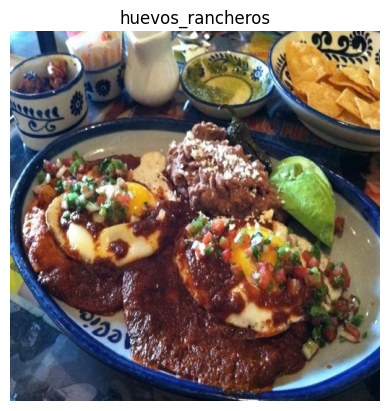

In [12]:
plt.imshow(image)
plt.title(CLASS_NAMES[label.numpy()])
plt.axis(False);

## Preprocessing the Data from TFDS


### Define the Color Space Conversion Function

In [6]:
#data preprocessing with color space transfrom
def to_other_color_space(image, new_color_space):
    if new_color_space is not None:
        new_image = convert_color_space(image, new_color_space)
        new_image = scale_0_to_255(new_image)
#         np.nan_to_num(new_image, copy=False, nan=0.0, posinf=255.0, neginf=0.0)
    else:
        new_image = image

    return new_image

def convert_color_space(image, new_color_space):
    new_image = image
    if hasattr(skimage.color, new_color_space.value) and callable(getattr(skimage.color, new_color_space.value)):
        # Call the method dynamically
        method = getattr(skimage.color, new_color_space.value)
        new_image = method(new_image)

    return new_image

def scale_0_to_255(image):
    converted_image = image
    for i in range(3):  # Iterate over RGB channels
        min_val = np.min(converted_image[:,:,i])
        max_val = np.max(converted_image[:,:,i])

        # Check if min and max are not equal
        if min_val != max_val:
            converted_image[:,:,i] = ((converted_image[:,:,i] - min_val) / (max_val - min_val)) * 255.

    return converted_image

In [7]:
def preprocess_img_a(image, label, img_size=224):
    label = tf.cast(label, dtype=tf.uint8)
    label = tf.one_hot(label, depth=ds_info.features["label"].num_classes)
    image = tf.image.resize(image, [img_size, img_size])
    image = to_other_color_space(image, COLOR_SPACE_A)
    image = tf.cast(image, tf.float16)
    return image, label

def preprocess_img_b(image, label, img_size=224):
    label = tf.cast(label, dtype=tf.uint8)
    label = tf.one_hot(label, depth=ds_info.features["label"].num_classes)
    image = tf.image.resize(image, [img_size, img_size])
    image = to_other_color_space(image, COLOR_SPACE_B)
    image = tf.cast(image, tf.float16)
    return image, label

In [15]:
# Trying the preprocess function on a single image

preprocessed_img_a = preprocess_img_a(image, label) #for cs_a
preprocessed_img_b = preprocess_img_b(image, label) #for cs_b

In [16]:
preprocessed_img_a

(<tf.Tensor: shape=(224, 224, 3), dtype=float16, numpy=
 array([[[230.6  , 253.6  , 251.   ],
         [223.   , 255.   , 252.2  ],
         [207.1  , 255.   , 250.4  ],
         ...,
         [140.6  , 129.5  , 121.25 ],
         [121.1  , 115.25 , 116.94 ],
         [ 83.94 ,  83.06 ,  89.6  ]],
 
        [[221.5  , 254.4  , 253.4  ],
         [214.5  , 255.   , 253.9  ],
         [198.4  , 254.6  , 252.   ],
         ...,
         [208.6  , 195.9  , 173.4  ],
         [197.   , 190.1  , 174.9  ],
         [175.5  , 171.6  , 161.2  ]],
 
        [[204.2  , 253.4  , 249.6  ],
         [198.8  , 254.6  , 251.2  ],
         [185.   , 251.8  , 252.2  ],
         ...,
         [222.5  , 207.5  , 169.4  ],
         [216.5  , 205.   , 172.   ],
         [215.5  , 207.9  , 177.6  ]],
 
        ...,
 
        [[ 47.12 ,  81.06 , 121.2  ],
         [ 30.4  ,  63.62 , 101.3  ],
         [127.4  , 158.9  , 193.   ],
         ...,
         [  3.953,  11.95 ,  23.38 ],
         [  2.27 ,  10.33 , 

In [17]:
preprocessed_img_b

(<tf.Tensor: shape=(224, 224, 3), dtype=float16, numpy=
 array([[[2.2838e+02, 2.4050e+02, 2.4550e+02],
         [2.2338e+02, 2.3962e+02, 2.4800e+02],
         [2.0950e+02, 2.3288e+02, 2.4375e+02],
         ...,
         [5.3562e+01, 5.1969e+01, 4.3969e+01],
         [4.0250e+01, 3.9031e+01, 3.9219e+01],
         [1.8109e+01, 1.7609e+01, 2.0328e+01]],
 
        [[2.2200e+02, 2.3812e+02, 2.5012e+02],
         [2.1700e+02, 2.3650e+02, 2.5125e+02],
         [2.0325e+02, 2.2925e+02, 2.4662e+02],
         ...,
         [1.3850e+02, 1.3762e+02, 1.0588e+02],
         [1.2662e+02, 1.2681e+02, 1.0625e+02],
         [9.8375e+01, 9.8750e+01, 8.6750e+01]],
 
        [[2.0550e+02, 2.2900e+02, 2.4162e+02],
         [2.0325e+02, 2.2938e+02, 2.4512e+02],
         [1.9150e+02, 2.1988e+02, 2.4600e+02],
         ...,
         [1.5638e+02, 1.5712e+02, 1.0369e+02],
         [1.5050e+02, 1.5188e+02, 1.0619e+02],
         [1.5300e+02, 1.5562e+02, 1.1356e+02]],
 
        ...,
 
        [[1.6141e+01, 1.5648e+01

### Define a Mapping Proxy

To address the error on SymbolicTensor not being able to be processed and thru Numpy, a tf.py_function is used

In [8]:
#create a py_function to address SymbolicTensor
def preprocess_with_py_function_a(image, label):
    # Wrap the preprocess_img_a function with tf.py_function
    return tf.py_function(func=lambda x, y: preprocess_img_a(x, y), inp=[image, label], Tout=[tf.float16, tf.float32])
def preprocess_with_py_function_b(image, label):
    # Wrap the preprocess_img_a function with tf.py_function
    return tf.py_function(func=lambda x, y: preprocess_img_b(x, y), inp=[image, label], Tout=[tf.float16, tf.float32])

## Define the Primary Data Generator

In [9]:
train_data_a = train_data.map(preprocess_with_py_function_a, tf.data.AUTOTUNE)
train_data_b = train_data.map(preprocess_with_py_function_b, tf.data.AUTOTUNE)
cs_train_dataset = Dataset.zip((train_data_a, train_data_b))
cs_train_dataset = cs_train_dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).repeat(EPOCHS).prefetch(tf.data.AUTOTUNE)

test_data_a = test_data.map(preprocess_with_py_function_a, tf.data.AUTOTUNE)
test_data_b = test_data.map(preprocess_with_py_function_b, tf.data.AUTOTUNE)
cs_test_dataset = Dataset.zip((test_data_a, test_data_b))
cs_test_dataset = cs_test_dataset.batch(BATCH_SIZE).repeat(EPOCHS)

In [10]:
cs_train_dataset
print(len(cs_train_dataset))
test_data
print(len(test_data))

118400
25250




### Mixed Precision Training
Taken from FoodVision Implementation

Mixed precision is used for training neural networks, reducing training time and memory requirements without affecting the model performance.

More Specifically, in **Mixed Precision** we will setting global dtype as `mixed_float16`. Because modern accelerators can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.

To know more about Mixed Precision, [**click here**](https://www.tensorflow.org/guide/mixed_precision)

In [11]:
#mixed precision to float 16
mixed_precision.set_global_policy(policy='mixed_float16')
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


2024-01-02 23:32:20.086947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


<Policy "mixed_float16">

## Creating the Model

In [22]:
def generate_siamese_cnn(base_model, input_shape, n_classes, data_aug_seed):
    network_input_a = Input(input_shape, name="input_layer_a")
    network_input_b = Input(input_shape, name="input_layer_b")

    network_input_a = preprocess_input(network_input_a)
    network_input_b = preprocess_input(network_input_b)
    
    siamese_arm = Sequential()
    siamese_arm.add(RandomRotation(factor=0.2, seed=data_aug_seed))
    siamese_arm.add(RandomFlip("horizontal_and_vertical", seed=data_aug_seed))
    siamese_arm.add(RandomTranslation(height_factor=0.2, width_factor=0.2, seed=data_aug_seed))
    siamese_arm.add(base_model)
    siamese_arm.add(GlobalAveragePooling2D(name="pooling_layer"))
    siamese_arm.add(Dropout(0.3))
    
    network_output_a = siamese_arm(network_input_a)
    network_output_b = siamese_arm(network_input_b)
    
    network_concat = Concatenate()([network_output_a, network_output_b])
    
    final_network = Dense(2560, activation='relu')(network_concat)
#     final_network = Dropout(0.5)(final_network)
    final_network = tf.keras.layers.Reshape((1, 1, 2560))(final_network)
    final_network = GlobalAveragePooling2D(name="classification_pooling")(final_network)
#     final_network = Dense(1280, activation='relu')(final_network) #try to remove this or add another pooling after this
    final_network = Dropout(0.4)(final_network)
    
    final_network = Dense(n_classes)(final_network)
    final_network_output = Activation("softmax")(final_network)
    
    siamese_model = Model(inputs=[network_input_a, network_input_b], outputs=[final_network_output])

    return siamese_model

In [23]:
# Load the MobileNet pre-trained model
base_model = BASE_MODEL(include_top=False)#, input_shape=INPUT_SHAPE, weights='imagenet')

# Create Siamese model
CURRENT_MODEL = generate_siamese_cnn(base_model, INPUT_SHAPE, N_CLASSES, DATA_AUG_SEED)

# Compile the model
CURRENT_MODEL.compile(loss= LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=[TOP5_ACC, "accuracy"])

CURRENT_MODEL.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer_a (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_layer_b (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 1280)                 6575239   ['input_layer_a[0][0]',       
                                                                     'input_layer_b[0][0]']       
                                                                                                  
 concatenate (Concatenate)   (None, 2560)                 0         ['sequential[0][0]',      

<h3>Define the custom siamese input generator</h3>

In [12]:
def generate_siamese_input_pair(cs_siamese_dataset):
    iterator = iter(cs_siamese_dataset)

    for data_a, data_b in iterator:
#     for data_a in iterator:
        X1, y1 = data_a
        X2, y2 = data_b

        yield [X1, X2], y1
#         yield X1, y1

### Define the Callbacks

In [25]:
# EarlyStopping Callback
early_stopping_callback = EarlyStopping(restore_best_weights=True,
                                        patience=3,
                                        verbose=1,
                                        monitor="val_accuracy")

# ReduceLROnPlateau Callback
lower_lr = ReduceLROnPlateau(factor=0.2,
                                monitor='val_accuracy',
                                min_lr=1e-7,
                                patience=0,
                                verbose=1)

#save best model
best_model_file=ROOT_FOLDER+"saved_models/"+SAVE_FILENAME+"_50epochs.h5"
checkpoint = ModelCheckpoint(filepath=best_model_file,
                                verbose=1,
                                monitor='val_accuracy',
                                save_best_only=True)

In [26]:
#https://stackoverflow.com/questions/57181551/can-i-write-a-keras-callback-that-records-and-returns-the-total-training-time
from timeit import default_timer as timer

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

timing_callback = TimingCallback()

## Start the Model Training

In [27]:
history = CURRENT_MODEL.fit(generate_siamese_input_pair(cs_train_dataset),
                    epochs=EPOCHS,
                    # steps_per_epoch=len(cs_train_dataset),
                    steps_per_epoch=int(len(cs_train_dataset) / EPOCHS), #50 is the epoch
                    validation_data=generate_siamese_input_pair(cs_test_dataset),
                    validation_steps=int(0.15 * (len(cs_test_dataset) /EPOCHS)),
                    callbacks=[create_tensorboard_callback("training-logs", "EfficientNetB1-"),
                               early_stopping_callback,
                               timing_callback,
                               lower_lr,
                               checkpoint])

Saving TensorBoard log files to: training-logs/EfficientNetB1-/20240102-181936
Epoch 1/50


2024-01-02 18:20:37.432303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-02 18:20:43.821050: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1fd473a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 18:20:43.821091: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-01-02 18:20:44.409167: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-02 18:20:47.051200: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - ETA: 0s - loss: 2.2720 - top_k_categorical_accuracy: 0.7141 - accuracy: 0.4466

2024-01-02 18:38:22.818904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 584 of 1000
2024-01-02 18:38:27.087753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 1: val_accuracy improved from -inf to 0.51880, saving model to saved_models/Siamese-v2_50epochs.h5


/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2368/2368 [==============================] - 1159s 452ms/step - loss: 2.2720 - top_k_categorical_accuracy: 0.7141 - accuracy: 0.4466 - val_loss: 1.9822 - val_top_k_categorical_accuracy: 0.7889 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 2/50
2368/2368 [==============================] - ETA: 0s - loss: 1.7089 - top_k_categorical_accuracy: 0.8199 - accuracy: 0.5688

2024-01-02 18:56:13.570367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 419 of 1000
2024-01-02 18:56:23.486633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 2: val_accuracy improved from 0.51880 to 0.58898, saving model to saved_models/Siamese-v2_50epochs.h5
2368/2368 [==============================] - 1079s 456ms/step - loss: 1.7089 - top_k_categorical_accuracy: 0.8199 - accuracy: 0.5688 - val_loss: 1.6192 - val_top_k_categorical_accuracy: 0.8469 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 3/50
2368/2368 [==============================] - ETA: 0s - loss: 1.5518 - top_k_categorical_accuracy: 0.8463 - accuracy: 0.6070

2024-01-02 19:14:04.733237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 310 of 1000
2024-01-02 19:14:14.732093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 900 of 1000
2024-01-02 19:14:16.402744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 3: val_accuracy improved from 0.58898 to 0.62500, saving model to saved_models/Siamese-v2_50epochs.h5
2368/2368 [==============================] - 1085s 458ms/step - loss: 1.5518 - top_k_categorical_accuracy: 0.8463 - accuracy: 0.6070 - val_loss: 1.4765 - val_top_k_categorical_accuracy: 0.8573 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/50
2368/2368 [==============================] - ETA: 0s - loss: 1.4260 - top_k_categorical_accuracy: 0.8633 - accuracy: 0.6367

2024-01-02 19:32:02.133115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 215 of 1000
2024-01-02 19:32:12.130589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 729 of 1000
2024-01-02 19:32:17.371842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy did not improve from 0.62500
2368/2368 [==============================] - 1068s 451ms/step - loss: 1.4260 - top_k_categorical_accuracy: 0.8633 - accuracy: 0.6367 - val_loss: 1.5225 - val_top_k_categorical_accuracy: 0.8602 - val_accuracy: 0.6165 - lr: 0.0010
Epoch 5/50
2368/2368 [==============================] - ETA: 0s - loss: 0.9940 - top_k_categorical_accuracy: 0.9166 - accuracy: 0.7357

2024-01-02 19:49:54.950196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 275 of 1000
2024-01-02 19:50:04.760063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 848 of 1000
2024-01-02 19:50:07.283961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 5: val_accuracy improved from 0.62500 to 0.78019, saving model to saved_models/Siamese-v2_50epochs.h5
2368/2368 [==============================] - 1092s 461ms/step - loss: 0.9940 - top_k_categorical_accuracy: 0.9166 - accuracy: 0.7357 - val_loss: 0.8453 - val_top_k_categorical_accuracy: 0.9396 - val_accuracy: 0.7802 - lr: 2.0000e-04
Epoch 6/50
2368/2368 [==============================] - ETA: 0s - loss: 0.8524 - top_k_categorical_accuracy: 0.9332 - accuracy: 0.7713

2024-01-02 20:07:55.216428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 292 of 1000
2024-01-02 20:08:05.222916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 804 of 1000
2024-01-02 20:08:08.624045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 6: val_accuracy did not improve from 0.78019
2368/2368 [==============================] - 1058s 447ms/step - loss: 0.8524 - top_k_categorical_accuracy: 0.9332 - accuracy: 0.7713 - val_loss: 0.8316 - val_top_k_categorical_accuracy: 0.9439 - val_accuracy: 0.7789 - lr: 2.0000e-04
Epoch 7/50
2368/2368 [==============================] - ETA: 0s - loss: 0.7391 - top_k_categorical_accuracy: 0.9458 - accuracy: 0.7975

2024-01-02 20:26:00.392933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 282 of 1000
2024-01-02 20:26:10.398087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 767 of 1000
2024-01-02 20:26:16.179375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.



Epoch 7: val_accuracy improved from 0.78019 to 0.78938, saving model to saved_models/Siamese-v2_50epochs.h5
2368/2368 [==============================] - 1194s 504ms/step - loss: 0.7391 - top_k_categorical_accuracy: 0.9458 - accuracy: 0.7975 - val_loss: 0.8230 - val_top_k_categorical_accuracy: 0.9423 - val_accuracy: 0.7894 - lr: 4.0000e-05
Epoch 8/50
2368/2368 [==============================] - ETA: 0s - loss: 0.7020 - top_k_categorical_accuracy: 0.9494 - accuracy: 0.8053

2024-01-02 20:45:16.123028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 194 of 1000



Epoch 8: val_accuracy improved from 0.78938 to 0.79264, saving model to saved_models/Siamese-v2_50epochs.h5


2024-01-02 20:45:25.976347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 413 of 1000
2024-01-02 20:45:35.937549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


2368/2368 [==============================] - 1022s 431ms/step - loss: 0.7020 - top_k_categorical_accuracy: 0.9494 - accuracy: 0.8053 - val_loss: 0.7886 - val_top_k_categorical_accuracy: 0.9518 - val_accuracy: 0.7926 - lr: 4.0000e-05
Epoch 9/50
2368/2368 [==============================] - ETA: 0s - loss: 0.6775 - top_k_categorical_accuracy: 0.9520 - accuracy: 0.8118

2024-01-02 21:03:13.097555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 278 of 1000



Epoch 9: val_accuracy improved from 0.79264 to 0.80244, saving model to saved_models/Siamese-v2_50epochs.h5


2024-01-02 21:03:22.964629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 508 of 1000
2024-01-02 21:03:31.350459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


2368/2368 [==============================] - 1080s 456ms/step - loss: 0.6775 - top_k_categorical_accuracy: 0.9520 - accuracy: 0.8118 - val_loss: 0.7663 - val_top_k_categorical_accuracy: 0.9454 - val_accuracy: 0.8024 - lr: 4.0000e-05
Epoch 10/50
2368/2368 [==============================] - ETA: 0s - loss: 0.6561 - top_k_categorical_accuracy: 0.9540 - accuracy: 0.8168

2024-01-02 21:21:12.444539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 230 of 1000



Epoch 10: val_accuracy improved from 0.80244 to 0.81727, saving model to saved_models/Siamese-v2_50epochs.h5


2024-01-02 21:21:24.116235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 429 of 1000
2024-01-02 21:21:32.335264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 911 of 1000
2024-01-02 21:21:33.838091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


2368/2368 [==============================] - 1078s 455ms/step - loss: 0.6561 - top_k_categorical_accuracy: 0.9540 - accuracy: 0.8168 - val_loss: 0.7097 - val_top_k_categorical_accuracy: 0.9566 - val_accuracy: 0.8173 - lr: 4.0000e-05
Epoch 11/50
2368/2368 [==============================] - ETA: 0s - loss: 0.6374 - top_k_categorical_accuracy: 0.9559 - accuracy: 0.8214

2024-01-02 21:39:12.024299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 290 of 1000



Epoch 11: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 11: val_accuracy did not improve from 0.81727
2368/2368 [==============================] - 1062s 449ms/step - loss: 0.6374 - top_k_categorical_accuracy: 0.9559 - accuracy: 0.8214 - val_loss: 0.7977 - val_top_k_categorical_accuracy: 0.9486 - val_accuracy: 0.7956 - lr: 4.0000e-05
Epoch 12/50


2024-01-02 21:39:21.988344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 503 of 1000
2024-01-02 21:39:29.461779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


2368/2368 [==============================] - ETA: 0s - loss: 0.6091 - top_k_categorical_accuracy: 0.9582 - accuracy: 0.8288

2024-01-02 21:57:08.735941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 375 of 1000



Epoch 12: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 12: val_accuracy did not improve from 0.81727
2368/2368 [==============================] - 1078s 451ms/step - loss: 0.6091 - top_k_categorical_accuracy: 0.9582 - accuracy: 0.8288 - val_loss: 0.7296 - val_top_k_categorical_accuracy: 0.9497 - val_accuracy: 0.8083 - lr: 8.0000e-06
Epoch 13/50


2024-01-02 21:57:18.674251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 566 of 1000
2024-01-02 21:57:25.394246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


2368/2368 [==============================] - ETA: 0s - loss: 0.6108 - top_k_categorical_accuracy: 0.9596 - accuracy: 0.8277

2024-01-02 22:15:03.778564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 285 of 1000


Restoring model weights from the end of the best epoch: 10.

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 13: val_accuracy did not improve from 0.81727
2368/2368 [==============================] - 1075s 451ms/step - loss: 0.6108 - top_k_categorical_accuracy: 0.9596 - accuracy: 0.8277 - val_loss: 0.7991 - val_top_k_categorical_accuracy: 0.9497 - val_accuracy: 0.7905 - lr: 1.6000e-06
Epoch 13: early stopping


## Loading Model for evaluation

In [13]:
CURRENT_MODEL = load_model(ROOT_FOLDER+"saved_models/"+SAVE_FILENAME+"_final.h5") #add _final to the name for the analysis

### Saving the Model

In [28]:
# Saving the model in colab
CURRENT_MODEL.save(ROOT_FOLDER+"saved_models/"+SAVE_FILENAME+"_final.h5")

print(timing_callback.logs)
print(sum(timing_callback.logs))

2024-01-02 22:15:13.891235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 484 of 1000
2024-01-02 22:15:22.660130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


[1157.6536368178204, 1076.5287018250674, 1080.772631407017, 1067.6594590409659, 1078.6902966969647, 1057.4807736710645, 1179.6174834391568, 1007.0752262049355, 1062.6541163839865, 1062.0794632858597, 1062.080750724068, 1077.7556878281757, 1075.380945571931]
14045.429172897013


### Saving the Model History

In [29]:
# Save scores on train and validation sets
with open(ROOT_FOLDER+"pickle_files/"+SAVE_FILENAME+"_history.pkl", 'wb') as f:
    pickle.dump(history.history, f)

In [30]:
with open(ROOT_FOLDER+"pickle_files/"+SAVE_FILENAME+'_history.pkl', 'rb') as f:
    history = pickle.load(f)

## Graphing the Model Output

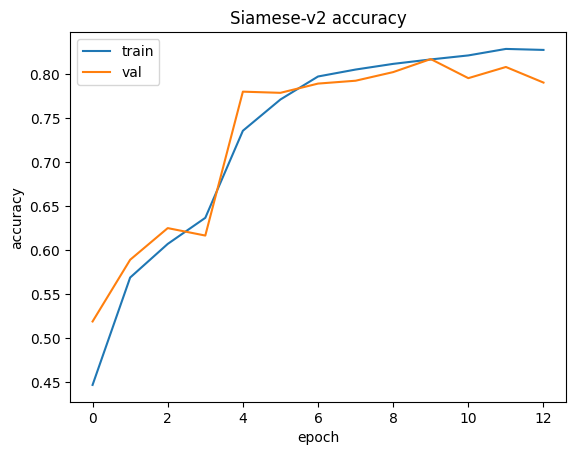

In [31]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title(SAVE_FILENAME+' accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(ROOT_FOLDER+"results/" + SAVE_FILENAME+ "-accuracy.pdf",bbox_inches='tight')
plt.show()

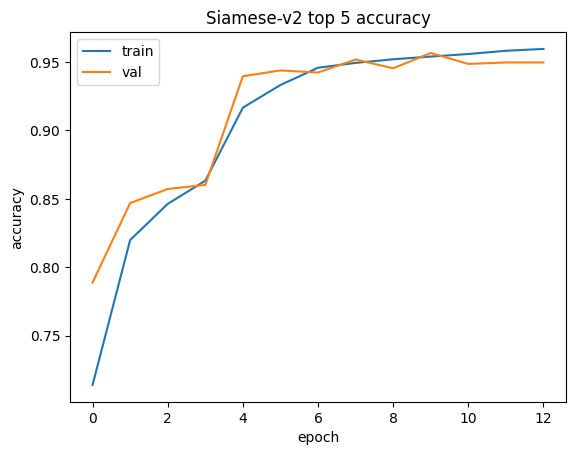

In [32]:
# summarize history for top 5 accuracy
plt.plot(history['top_k_categorical_accuracy'])
plt.plot(history['val_top_k_categorical_accuracy'])
plt.title(SAVE_FILENAME+' top 5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(ROOT_FOLDER+"results/" + SAVE_FILENAME+"-top5accuracy.pdf",bbox_inches='tight')
plt.show()

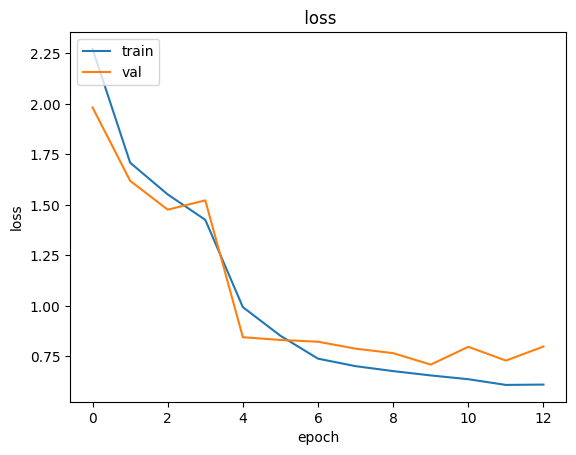

In [33]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title(' loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(ROOT_FOLDER+"results/" + SAVE_FILENAME + "-loss.pdf",bbox_inches='tight')
plt.show()

<h2>Evaluating the Model</h2>

In [34]:
test_data_a = test_data.map(preprocess_with_py_function_a, tf.data.AUTOTUNE)
test_data_b = test_data.map(preprocess_with_py_function_b, tf.data.AUTOTUNE)
cs_test_dataset = Dataset.zip((test_data_a, test_data_b))
cs_test_dataset = cs_test_dataset.batch(BATCH_SIZE)

In [35]:
print(len(cs_test_dataset))

790


In [36]:
CURRENT_MODEL.evaluate(generate_siamese_input_pair(cs_test_dataset), steps=len(cs_test_dataset))

790/790 [==============================] - 281s 356ms/step - loss: 0.7663 - top_k_categorical_accuracy: 0.9504 - accuracy: 0.8007


[0.7663179039955139, 0.950415849685669, 0.800673246383667]

In [37]:
%load_ext tensorboard
%tensorboard --logdir training-logs

In [14]:
test_data_a = test_data.map(preprocess_with_py_function_a, tf.data.AUTOTUNE)
test_data_b = test_data.map(preprocess_with_py_function_b, tf.data.AUTOTUNE)
cs_test_dataset = Dataset.zip((test_data_a, test_data_b))
cs_test_dataset = cs_test_dataset.batch(BATCH_SIZE)

In [15]:
pred_probs = CURRENT_MODEL.predict(generate_siamese_input_pair(cs_test_dataset), steps=len(cs_test_dataset), verbose=1)
len(pred_probs), pred_probs.shape

2024-01-02 23:33:29.729753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


790/790 [==============================] - 230s 256ms/step


(25250, (25250, 101))

In [16]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [17]:
# Getting true labels for the test_data

y_labels = []
test_images = []
for images, labels in test_data:
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [18]:
# Predicted Labels vs. True Labels
pred_classes==y_labels

array([ True,  True,  True, ..., False,  True,  True])

### SkLearn Scores

In [19]:
sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.8006732673267327

### Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

In [20]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

### Model's Class-wise Accuracy Score

In [21]:
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [22]:
report_table = classification_report(y_labels, pred_classes, target_names=CLASS_NAMES, digits=4)

In [23]:
print(report_table)

                         precision    recall  f1-score   support

              apple_pie     0.5492    0.5360    0.5425       250
         baby_back_ribs     0.8069    0.7520    0.7785       250
                baklava     0.7986    0.9040    0.8480       250
         beef_carpaccio     0.8295    0.8760    0.8521       250
           beef_tartare     0.8683    0.7120    0.7824       250
             beet_salad     0.7421    0.7480    0.7450       250
               beignets     0.7204    0.8760    0.7906       250
               bibimbap     0.9481    0.8760    0.9106       250
          bread_pudding     0.6164    0.5720    0.5934       250
      breakfast_burrito     0.7762    0.6520    0.7087       250
             bruschetta     0.8402    0.6520    0.7342       250
           caesar_salad     0.7710    0.9160    0.8373       250
                cannoli     0.8577    0.8200    0.8384       250
          caprese_salad     0.8553    0.8040    0.8289       250
            carrot_cake 

In [24]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[CLASS_NAMES[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.54251012145749,
 'baby_back_ribs': 0.7784679089026915,
 'baklava': 0.8480300187617261,
 'beef_carpaccio': 0.8521400778210118,
 'beef_tartare': 0.7824175824175823,
 'beet_salad': 0.7450199203187251,
 'beignets': 0.7906137184115525,
 'bibimbap': 0.9106029106029107,
 'bread_pudding': 0.5933609958506224,
 'breakfast_burrito': 0.708695652173913,
 'bruschetta': 0.7342342342342343,
 'caesar_salad': 0.8372943327239489,
 'cannoli': 0.838445807770961,
 'caprese_salad': 0.8288659793814432,
 'carrot_cake': 0.7753303964757708,
 'ceviche': 0.728813559322034,
 'cheesecake': 0.6823529411764705,
 'cheese_plate': 0.8627450980392156,
 'chicken_curry': 0.7638603696098563,
 'chicken_quesadilla': 0.816,
 'chicken_wings': 0.8619246861924686,
 'chocolate_cake': 0.6711864406779662,
 'chocolate_mousse': 0.5486725663716814,
 'churros': 0.8805031446540881,
 'clam_chowder': 0.8513011152416358,
 'club_sandwich': 0.8781431334622823,
 'crab_cakes': 0.7583333333333333,
 'creme_brulee': 0.89546351084812

In [25]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T

In [26]:
report_df = report_df.sort_values("f1-scores", ascending=True)

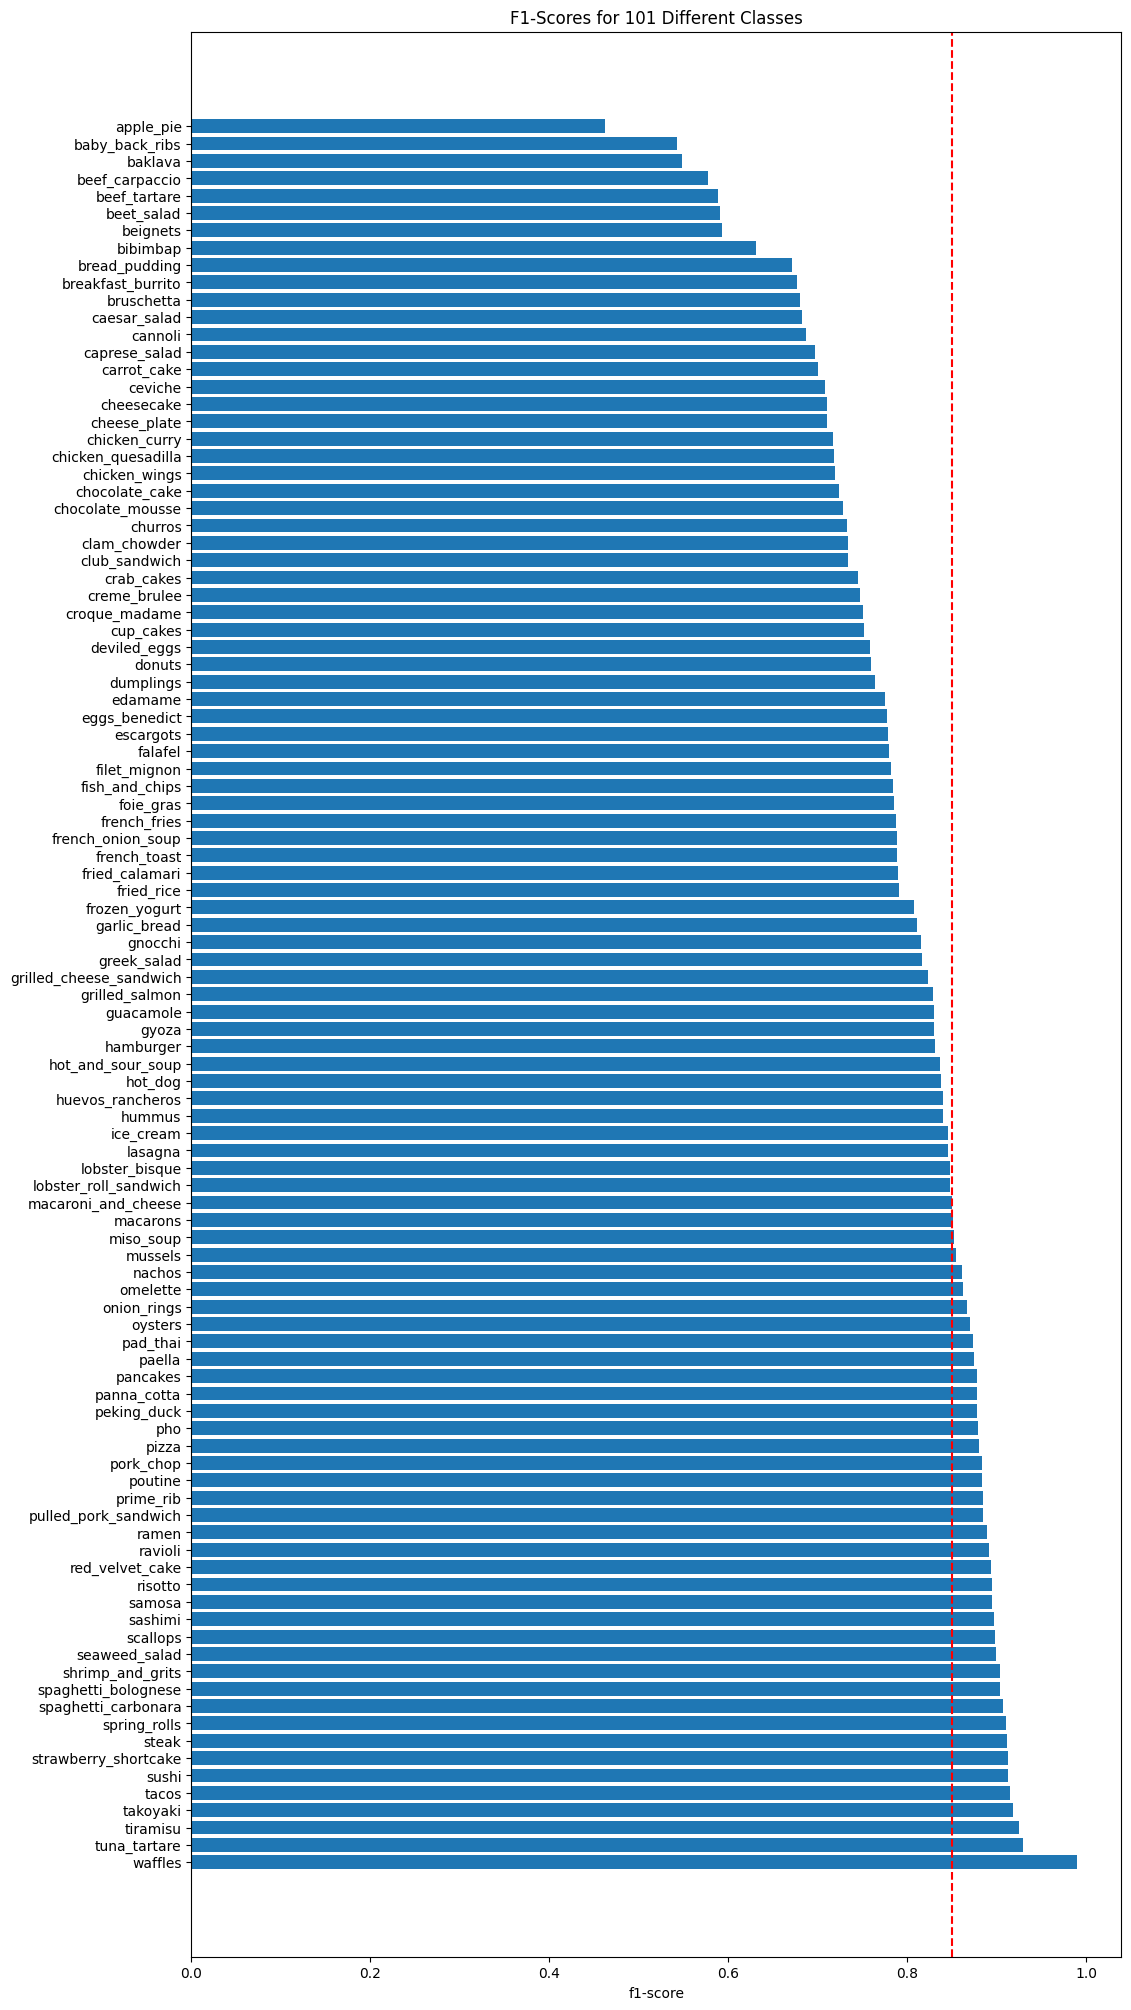

In [27]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(report_df)), report_df["f1-scores"].values)
ax.set_yticks(range(len(report_df)))
plt.axvline(x=0.85, linestyle='--', color='r')
ax.set_yticklabels(CLASS_NAMES)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # reverse the order

### Predicting on our own Custom images

Once we have our model ready, its cruicial to evaluate it on our custom data : the data our model has never seen.

Training and evaluating a model on train and test data is cool, but making predictions on our own realtime images is another level.



In [28]:
def preproc_custom_test(proc_img, color_space_a, color_space_b):

    cs_a = preprocess_img_a(proc_img, 0)[0]
    cs_a = tf.expand_dims(cs_a, axis=0)

    cs_b = preprocess_img_b(proc_img, 0)[0]
    cs_b = tf.expand_dims(cs_b, axis=0)

    return [cs_a, cs_b]
#     return cs_a

<h3>CNN</h3>

In [ ]:
def pred_plot_custom(folder_path, model):
  import os

  custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path)]
  i=0
  fig,a =  plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)))

  for img in custom_food_images:
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = CLASS_NAMES[pred_prob.argmax()]
    top_5_i = (pred_prob.argsort())[0][-5:][::-1]
    values = pred_prob[0][top_5_i]
    labels = []
    for x in range(5):
      labels.append(CLASS_NAMES[top_5_i[x]])

    # Plotting Image
    a[i][0].imshow(img/255.)
    a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
    a[i][0].axis(False)

    # Plotting Models Top 5 Predictions
    a[i][1].bar(labels, values, color='orange');
    a[i][1].set_title('Top 5 Predictions')
    i=i+1

<h3>SCNN</h3>

In [29]:
def pred_plot_custom(folder_path, model, color_space_a, color_space_b):
    custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path)]
    i=0
    fig,a =  plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)))

    for img in custom_food_images:
        if not os.path.isfile(img):
            continue
        img = load_and_prep_image(img, scale=False) #used for display
        proc_img = tf.image.resize(img, IMG_SIZE)
#         pred_prob = model.predict(tf.expand_dims(img, axis=0))
        pred_prob =  model.predict(preproc_custom_test(proc_img, color_space_a, color_space_b))
        pred_class = CLASS_NAMES[pred_prob.argmax()]
        top_5_i = (pred_prob.argsort())[0][-5:][::-1]
        values = pred_prob[0][top_5_i]
        labels = []
        for x in range(5):
            labels.append(CLASS_NAMES[top_5_i[x]])

        # Plotting Image
        a[i][0].imshow(img/255.)
        a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
        a[i][0].axis(False)

        # Plotting Models Top 5 Predictions
        a[i][1].bar(labels, values, color='orange');
        a[i][1].set_title('Top 5 Predictions')
        i=i+1

In [ ]:
pred_plot_custom(ROOT_FOLDER+"Custom Images/", CURRENT_MODEL)

1/1 [==============================] - 0s 33ms/step


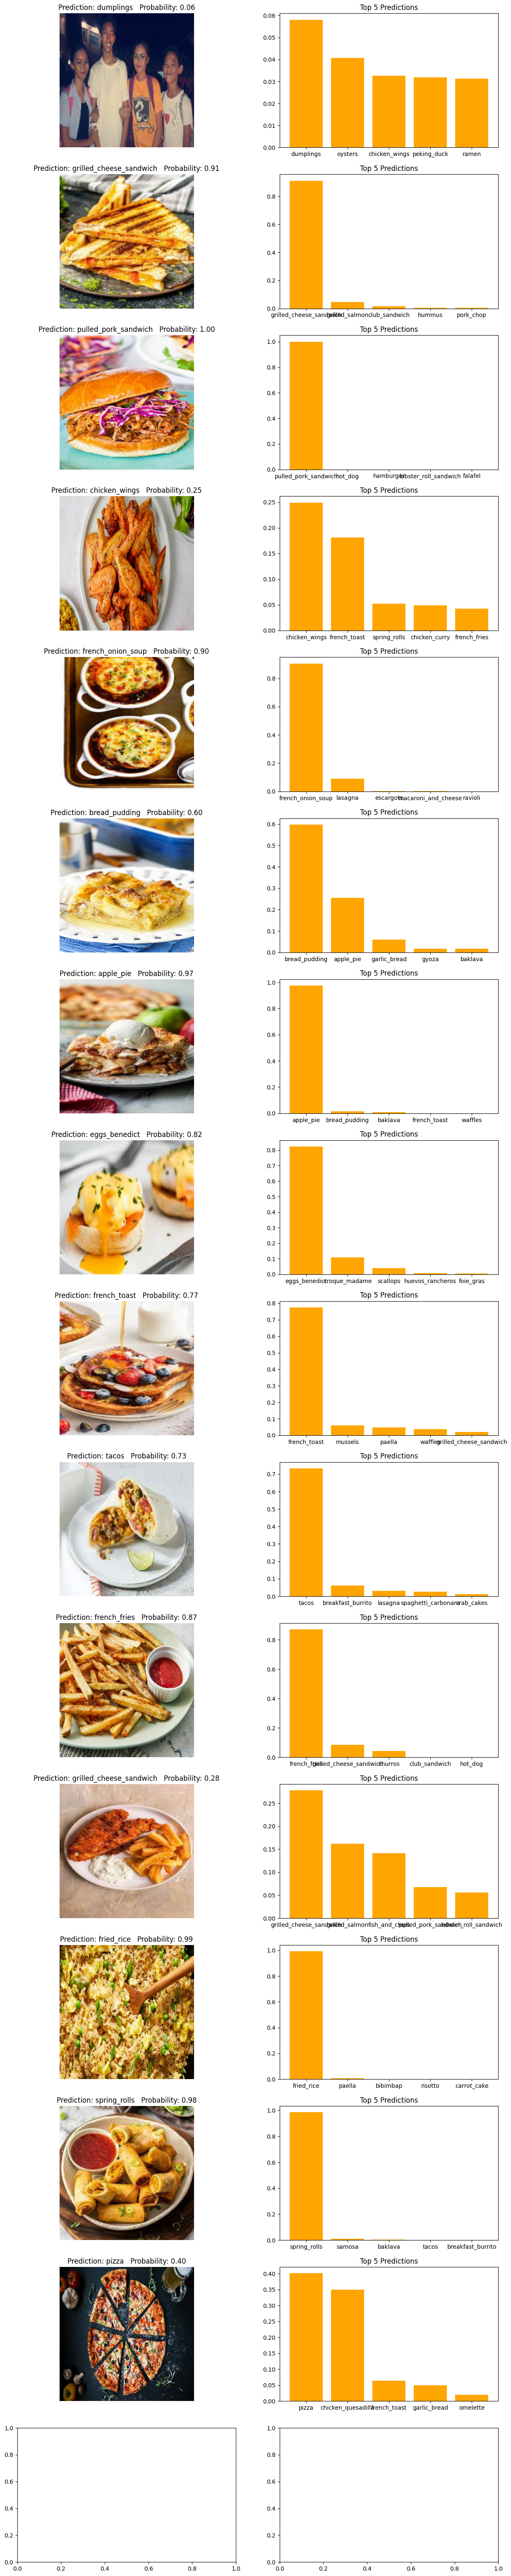

In [30]:
pred_plot_custom(ROOT_FOLDER+"Custom Images/", CURRENT_MODEL, COLOR_SPACE_A, COLOR_SPACE_B)